# Stock Price Prediction

In [16]:
## Import Dependencies
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torch.nn as nn
from datetime import date
import yfinance as yf
from typing import Tuple

### Data Collection and Preprocessing

In [3]:
# start_date = pd.to_datetime('2018-01-01')
# end_date = pd.to_datetime(date.today())

data = yf.download("AAPL", start="2006-01-01", end=date.today())
data.index

[*********************100%***********************]  1 of 1 completed


DatetimeIndex(['2006-01-03', '2006-01-04', '2006-01-05', '2006-01-06',
               '2006-01-09', '2006-01-10', '2006-01-11', '2006-01-12',
               '2006-01-13', '2006-01-17',
               ...
               '2023-02-08', '2023-02-09', '2023-02-10', '2023-02-13',
               '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17',
               '2023-02-21', '2023-02-22'],
              dtype='datetime64[ns]', name='Date', length=4314, freq=None)

Text(0.5, 1.0, 'APPL Stock Price')

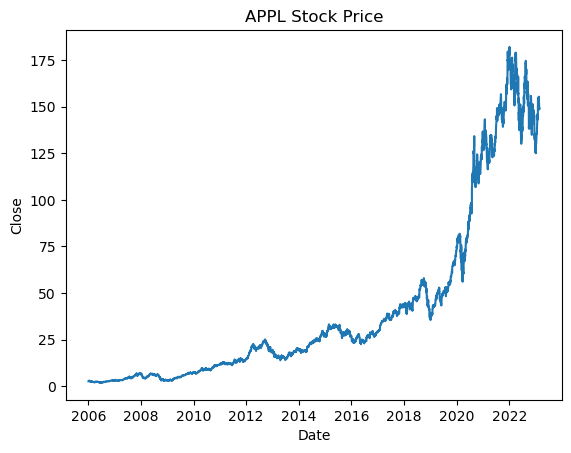

In [4]:
plt.plot(data.index, data.Close)
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("APPL Stock Price")


In [5]:
price = data[["Close"]]
print(price["Close"])
print(type(data.Close))

Date
2006-01-03      2.669643
2006-01-04      2.677500
2006-01-05      2.656429
2006-01-06      2.725000
2006-01-09      2.716071
                 ...    
2023-02-15    155.330002
2023-02-16    153.710007
2023-02-17    152.550003
2023-02-21    148.479996
2023-02-22    148.910004
Name: Close, Length: 4314, dtype: float64
<class 'pandas.core.series.Series'>


In [6]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler

price = data[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/var/folders/xh/q409xc5j2y585vzgtj75_75m0000gn/T/ipykernel_98864/2026306232.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [10]:
### Split data into Train Test

def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length


### Building Model using PyTorch

In [11]:
x_train, y_train, x_test, y_test = split_data(price, lookback)
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

####  1. Implementing Positional Encoding

In [12]:
from torch import nn, Tensor
import math

class PositionEncoder(nn.Module):
    '''
    We use positional encoding to encode the time stamps
    '''

    def __init__(self, dropout=0.1, max_len=5000, d_model=512, batch_first=False):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first
        self.x_dim = 1 if batch_first else 0

        # copy pasted from PyTorch tutorial
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(self.x_dim)]

        return self.dropout(x)

#### 2. Create a Time Series Transfomer

In [13]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        batch_first: bool,
        out_seq_len: int=58,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        num_predicted_features: int=1,
        max_seq_len: int=153
        ): 

        super().__init__() 

        self.dec_seq_len = dec_seq_len

        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )

        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val
            )  
        
        self.linear_mapping = nn.Linear(
            in_features=dim_val, 
            out_features=num_predicted_features
            )

        # Create positional encoder
        self.positional_encoding_layer = PositionEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc
            )

        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )

        # Stack the encoder layers in nn.TransformerDecoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
            )

        # Stack the decoder layers in nn.TransformerDecoder
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )
    
    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """

        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        #print("From model.forward(): tgt size = {}".format(tgt.size()))

        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder
        # Masking is only needed in the encoder if input sequences are padded
        # which they are not in this time series use case, because all my
        # input sequences are naturally of the same length. 
        # (https://github.com/huggingface/transformers/issues/4083)
        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        #print("From model.forward(): Size of src after encoder: {}".format(src.size()))

        # Pass decoder input through decoder input layer
        decoder_output = self.decoder_input_layer(tgt) # src shape: [target sequence length, batch_size, dim_val] regardless of number of input features
        #print("From model.forward(): Size of decoder_output after linear decoder layer: {}".format(decoder_output.size()))

        #if src_mask is not None:
            #print("From model.forward(): Size of src_mask: {}".format(src_mask.size()))
        #if tgt_mask is not None:
            #print("From model.forward(): Size of tgt_mask: {}".format(tgt_mask.size()))

        # Pass throguh decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )

        #print("From model.forward(): decoder_output shape after decoder: {}".format(decoder_output.shape))

        # Pass through linear mapping
        decoder_output = self.linear_mapping(decoder_output) # shape [batch_size, target seq len]
        #print("From model.forward(): decoder_output size after linear_mapping = {}".format(decoder_output.size()))

        return decoder_output



In [14]:
## Model parameters
dim_val = 512 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 1 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 92 # length of input given to decoder. Can have any integer value.
enc_seq_len = 153 # length of input given to encoder. Can have any integer value.
output_sequence_length = 58 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder

model = TimeSeriesTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    max_seq_len=max_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads,
    batch_first=True)

In [17]:
def get_src_trg(
        self,
        sequence: torch.Tensor, 
        enc_seq_len: int, 
        target_seq_len: int
        ) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:

        """
        Generate the src (encoder input), trg (decoder input) and trg_y (the target)
        sequences from a sequence. 

        Args:

            sequence: tensor, a 1D tensor of length n where 
                    n = encoder input length + target sequence length  

            enc_seq_len: int, the desired length of the input to the transformer encoder

            target_seq_len: int, the desired length of the target sequence (the 
                            one against which the model output is compared)

        Return: 

            src: tensor, 1D, used as input to the transformer model

            trg: tensor, 1D, used as input to the transformer model

            trg_y: tensor, 1D, the target sequence against which the model output
                is compared when computing loss. 
        
        """
        #print("Called dataset.TransformerDataset.get_src_trg")
        assert len(sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"
        
        #print("From data.TransformerDataset.get_src_trg: sequence shape: {}".format(sequence.shape))

        # encoder input
        src = sequence[:enc_seq_len] 
        
        # decoder input. As per the paper, it must have the same dimension as the 
        # target sequence, and it must contain the last value of src, and all
        # values of trg_y except the last (i.e. it must be shifted right by 1)
        trg = sequence[enc_seq_len-1:len(sequence)-1]

        #print("From data.TransformerDataset.get_src_trg: trg shape before slice: {}".format(trg.shape))

        trg = trg[:, 0]

        #print("From data.TransformerDataset.get_src_trg: trg shape after slice: {}".format(trg.shape))

        if len(trg.shape) == 1:

            trg = trg.unsqueeze(-1)

            #print("From data.TransformerDataset.get_src_trg: trg shape after unsqueeze: {}".format(trg.shape))

        
        assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"

        # The target sequence against which the model output will be compared to compute loss
        trg_y = sequence[-target_seq_len:]

        #print("From data.TransformerDataset.get_src_trg: trg_y shape before slice: {}".format(trg_y.shape))

        # We only want trg_y to consist of the target variable not any potential exogenous variables
        trg_y = trg_y[:, 0]

        #print("From data.TransformerDataset.get_src_trg: trg_y shape after slice: {}".format(trg_y.shape))

        assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"

        return src, trg, trg_y.squeeze(-1) # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len] 


In [20]:

def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Source:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    Args:

        dim1: int, for both src and tgt masking, this must be target sequence
              length

        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 


    Return:

        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)

# Input length
enc_seq_len = 100

# Output length
output_sequence_length = 58

# Make src mask for decoder with size:
tgt_mask = generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=output_sequence_length
   )

src_mask = generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=enc_seq_len
    )


In [21]:
output = model(
    src=src, 
    tgt=trg,
    src_mask=src_mask,
    tgt_mask=tgt_mask
    )

NameError: name 'src' is not defined